## Module Imports

In [1]:
import tensorflow as tf

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from tensorflow import keras
from tensorflow.keras import layers

## Download data

In [2]:
# Download data. Save the path where the file is downloaded locally into dataset_path
dataset_path = "./data/auto-mpg.data"

## Read the data into a DataFrame

Use `delim_whitespace` to make the separator in `pd.read_csv` more flexible. 

In [3]:
# Missing values in this dataset are denoted using ?
column_names = ["mpg", "cylinders", "displacement", "horsepower", "weight",
                "acceleration", "model_year", "origin", "car_name"]
dataset = pd.read_csv(dataset_path, names=column_names, delim_whitespace=True,
                      na_values="?")
print (dataset.shape)

(398, 9)


### Data Inspection

In [4]:
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


### Inspect Column Datatypes

In [5]:
dataset.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

### Handle missing data

We have 2 options when it comes to handling missing data.
1. Drop all rows containing missing data.
2. Use an Imputer with a replacement strategy for each column that has missing data.

In [6]:
dataset.dropna(inplace=True)

### Look at overall data statistics

In [7]:
dataset.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


## Visualize Data

Plot pairwise relationship in the original dataset (The dataset got after handling missing values) using seaborn

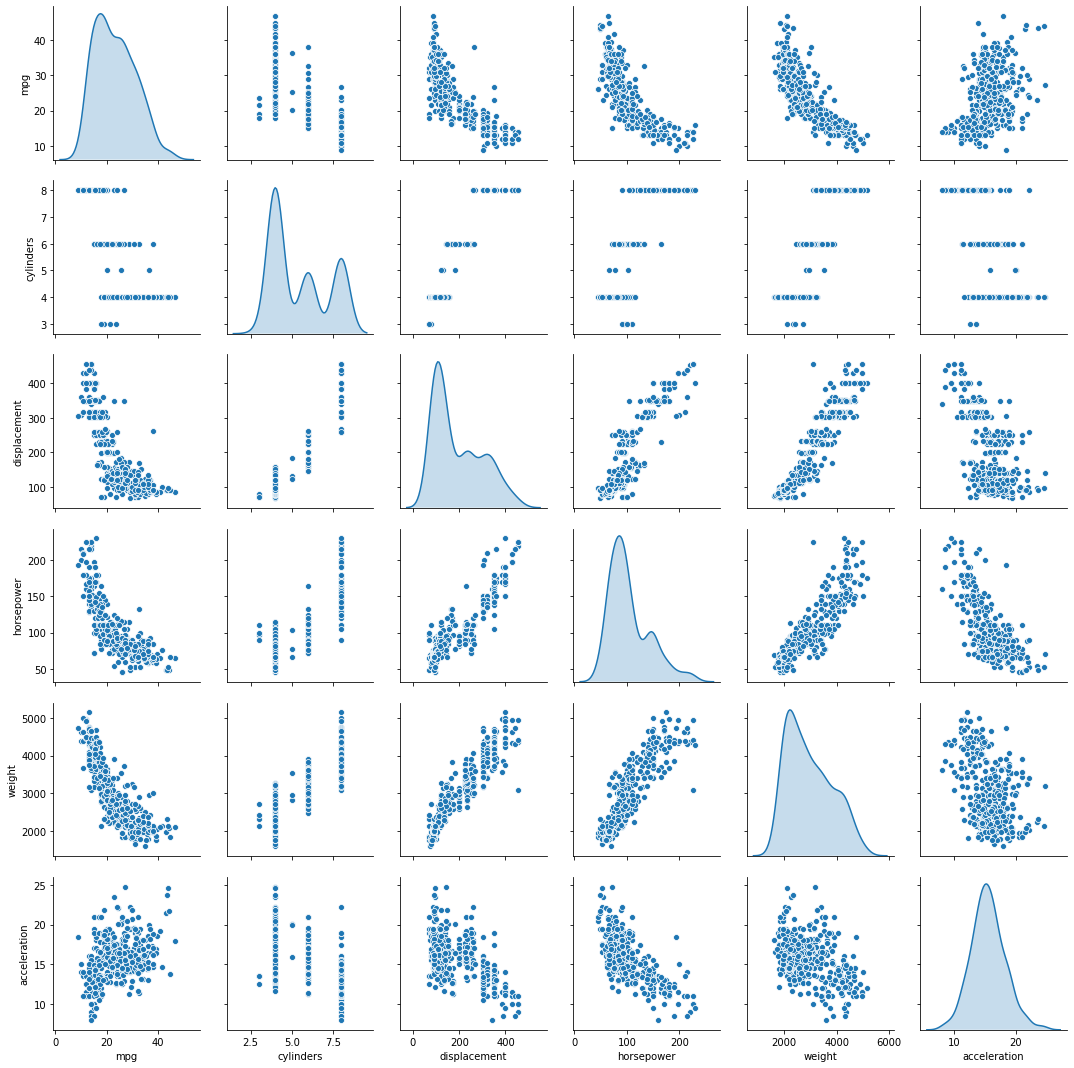

In [8]:
sns.pairplot(dataset[["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration"]],
             diag_kind="kde")

## Data Transformation Pipeline

1. Scale all the numerical data. We have 2 options
    1. `StandardScaler`
    2. `MinMaxScaler`
2. Convert all the categorical data. We have 2 options
    1. `LabelEncoder`
    2. `OneHotEncoder`

Use a `ColumnTransformer` to apply the above transformations to the right column. After calling `fit_transform` we get back a numpy array which can then be re-converted into a Pandas Dataframe.

In [9]:
numeric_pipeline = Pipeline([
    ("number_scaler", MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ("one_hot", OneHotEncoder(categories="auto"))
])

numeric_columns = ["cylinders", "displacement", "horsepower",
                   "weight", "acceleration", "model_year"]
categorical_columns = ["origin"]
data_transformer = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns),
    ("categorical", categorical_pipeline, categorical_columns)
])
transformed_numpy_data = data_transformer.fit_transform(dataset)

transformed_dataset = pd.DataFrame({
    'mpg' : dataset["mpg"],
    'cylinders' : transformed_numpy_data[:, 0],
    'displacement' : transformed_numpy_data[:, 1],
    'horsepower' : transformed_numpy_data[:, 2],
    'weight' : transformed_numpy_data[:, 3],
    'acceleration' : transformed_numpy_data[:, 4],
    'model_year' : transformed_numpy_data[:, 5],
    'origin_CAT1' : transformed_numpy_data[:, 6],
    'origin_CAT2' : transformed_numpy_data[:, 7],
    'origin_CAT3' : transformed_numpy_data[:, 8]
})

### Tranformed Data Inspection

In [10]:
transformed_dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_CAT1,origin_CAT2,origin_CAT3
0,18.0,1.0,0.617571,0.456522,0.536150,0.238095,0.0,1.0,0.0,0.0
1,15.0,1.0,0.728682,0.646739,0.589736,0.208333,0.0,1.0,0.0,0.0
2,18.0,1.0,0.645995,0.565217,0.516870,0.178571,0.0,1.0,0.0,0.0
3,16.0,1.0,0.609819,0.565217,0.516019,0.238095,0.0,1.0,0.0,0.0
4,17.0,1.0,0.604651,0.510870,0.520556,0.148810,0.0,1.0,0.0,0.0


## Split the data into train and test

Also separate the target value, or "label", from the input features. This label is the value that you will train the model to predict.

In [11]:
train_dataset = transformed_dataset.sample(frac=0.8,random_state=0)
test_dataset = transformed_dataset.drop(train_dataset.index)

train_labels = train_dataset.pop("mpg")
test_labels = test_dataset.pop("mpg")

train_dataset.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_CAT1,origin_CAT2,origin_CAT3
146,0.2,0.056848,0.157609,0.145166,0.386905,0.333333,1.0,0.0,0.0
282,0.2,0.186047,0.228261,0.362064,0.553571,0.750000,1.0,0.0,0.0
69,1.0,0.728682,0.619565,0.806067,0.327381,0.166667,1.0,0.0,0.0
378,0.2,0.095607,0.092391,0.145166,0.398810,1.000000,1.0,0.0,0.0
331,0.2,0.074935,0.114130,0.150836,0.595238,0.833333,0.0,0.0,1.0


## Build the Regression Model using NN architecture

1. Keras Sequential Model is a linear stack of layers
2. You have multiple options for Layers. Ex - Dense, Activation, Dropout etc

In this example we have 2 Hidden Dense Layers and 1 Output Layer. The Hidden Dense Layers have 64 hidden units each and they make use of the ReLU Activation function. 

After adding the layers you add a Keras Optimizer as well. Every time a neural network finishes passing a batch through the network and generating prediction results, it must decide how to use the difference between the results it got and the values it knows to be true to adjust the weights on the nodes so that the network steps towards a solution. The algorithm that determines that step is known as the optimization algorithm.

In [12]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", use_bias=True, kernel_initializer="random_uniform",
                     bias_initializer="zeros", input_shape=(len(train_dataset.columns),)),
        layers.Dense(64, activation="relu", use_bias=True, kernel_initializer="random_uniform",
                     bias_initializer="zeros"),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [14]:
EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
# Use EarlyStopping to automatically stop training when the validation score doesn't improve.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split=0.2,
                    verbose=0, callbacks=[early_stop])

### Turn the History object to a Pandas Dataframe

In [15]:
historyDF = pd.DataFrame(history.history)
historyDF["epoch"] = history.epoch
historyDF.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
134,8.932420,2.144973,8.932420,8.617592,2.331148,8.617593,134
135,8.917844,2.148824,8.917844,7.836734,2.156240,7.836734,135
136,8.971711,2.164473,8.971712,8.331352,2.271628,8.331352,136
137,8.883494,2.160928,8.883495,7.807039,2.119795,7.807039,137
138,9.005019,2.219990,9.005019,7.798301,2.131103,7.798301,138


### Plot MAE And MSE for Training and Validation

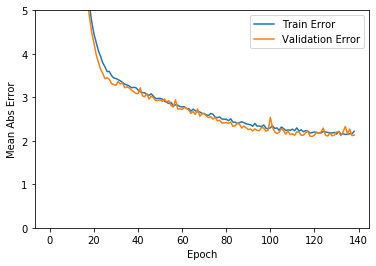

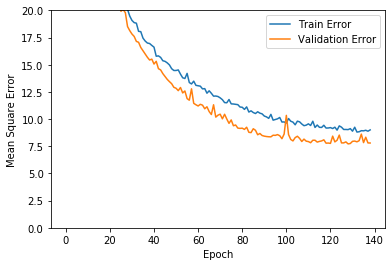

In [16]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(historyDF['epoch'], historyDF['mae'], label='Train Error')
plt.plot(historyDF['epoch'], historyDF['val_mae'], label = 'Validation Error')
plt.ylim([0,5])
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(historyDF['epoch'], historyDF['mse'], label='Train Error')
plt.plot(historyDF['epoch'], historyDF['val_mse'], label = 'Validation Error')
plt.ylim([0,20])
plt.legend()
plt.show()

## Test the model

In [17]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.5849 - mae: 1.9231 - mse: 6.5849
Testing set Mean Abs Error:  1.92 MPG


## Make Predictions

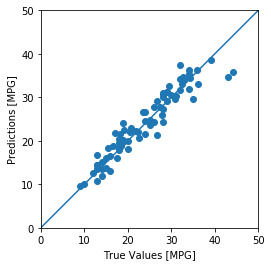

In [18]:
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)